In [1]:
import numpy as np
import numpy.random as rn
rn.seed(764)

from pathlib import Path

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('axes', linewidth=0.8)

colors = {'gray':'#D4D4D4', 'darkgray':'#545454', 
          'male':'#FF5E74', 'male_light':'#FFABB6', 
          'female':'#00B7FF', 'female_light':'#9EE3FF'}

# Get colors for heatmaps
from matplotlib import colormaps as cm
colormaker = cm.get_cmap('PRGn')
cmap = [colormaker(0.1), colormaker(0.5), colormaker(0.9)]

# Change to your data directory
basedir = Path('/Volumes/data-1/behavior/hakan')


### Load data

In [2]:
# Load the preferences for all mice to sort the plots
data_path = basedir/'Kucukdereli_atal_data/data_table_all_mice.h5'
data_df = pd.read_hdf(data_path, key='data')


## Figure S2A

### Calculate the null distributions for the preferences of **male mice**

In [3]:
# Load the raw behavior data
data_path = basedir/'Kucukdereli_atal_data/raw_behavior_data_males.h5'
table = pd.read_hdf(data_path, key='data')

# Sort the data by the preference from the day 5 of RTPP
males = data_df.sort_values([('test_',5)]).query('@data_df.mouse.sex=="male"')['mouse','mouse'].to_numpy()
table = pd.concat([table.query('mouse==@mouse') for mouse in males], ignore_index=True)


### Baseline days (**males**)

100%|██████████| 15/15 [01:53<00:00,  7.54s/it]


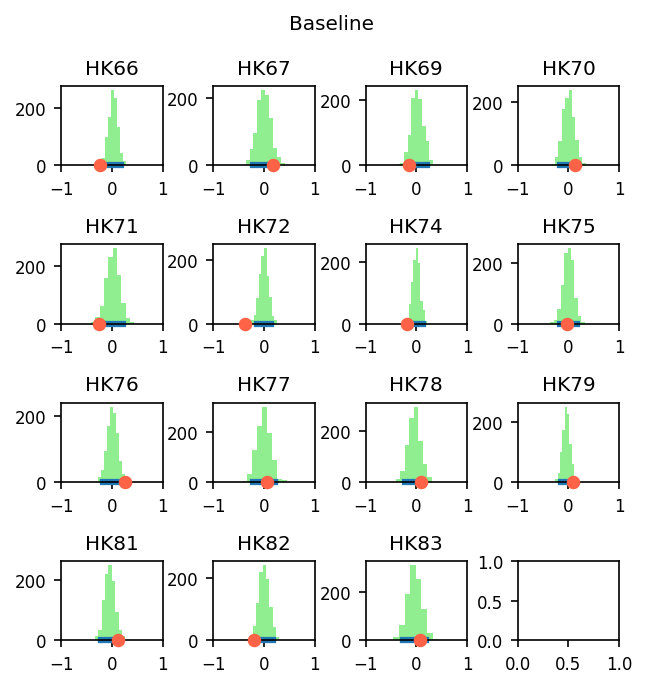

In [4]:
shuffle_n = 1000

m = np.ceil(np.sqrt(len(males))).astype(int)
n = np.ceil(len(males)/m).astype(int)
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=0.5)
fig.suptitle('Baseline')
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment), df in tqdm(table.query("experiment in ['preference'] & day in [1,2]").groupby(['mouse','experiment'])):
    if len(df):
        trial_n1 = df.query("day==1").query("session==1").cueid.unique()
        stim_n1 = df.query("day==1").query('stim>0 & session==1').stim.unique()
        neutral_n1 = df.query("day==1").query('neutral>0 & session==1').neutral.unique()
        trial_n2 = df.query("day==2").query("session==1").cueid.unique()
        stim_n2 = df.query("day==2").query('stim>0 & session==1').stim.unique()
        neutral_n2 = df.query("day==2").query('neutral>0 & session==1').neutral.unique()
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials1 = np.random.choice(trial_n1, size=len(stim_n1), replace=False)
            neutral_trials1 = np.random.choice(trial_n1, size=len(neutral_n1), replace=False)
            stim_trials2 = np.random.choice(trial_n2, size=len(stim_n2), replace=False)
            neutral_trials2 = np.random.choice(trial_n2, size=len(neutral_n2), replace=False)
            
            stim_t1 = df.query("day==1 & cueid in @stim_trials1 & dwell==True & session==1").dt.sum()
            neutral_t1 = df.query("day==1 & cueid in @neutral_trials1 & dwell==True & session==1").dt.sum()
            stim_t2 = df.query("day==2 & cueid in @stim_trials2 & dwell==True & session==1").dt.sum()
            neutral_t2 = df.query("day==2 & cueid in @neutral_trials2 & dwell==True & session==1").dt.sum()
            stim_t = stim_t1 + stim_t2
            neutral_t = neutral_t1 + neutral_t2
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci5, ci95 = np.quantile(pref_dist, [.05, .95])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':1,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t1 = df.query("day==1 & stim>0 & dwell==True & session==1").dt.sum()
        neutral_t1 = df.query("day==1 & neutral>0 & dwell==True & session==1").dt.sum()
        stim_t2 = df.query("day==2 & stim>0 & dwell==True & session==1").dt.sum()
        neutral_t2 = df.query("day==2 & neutral>0 & dwell==True & session==1").dt.sum()
        stim_t = stim_t1 + stim_t2
        neutral_t = neutral_t1 + neutral_t2
            
        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':1,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen');
        ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        ax.set_title(f"{mouse}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci5,ci95], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_male_preference = pref_df
pref_dist_df_male_preference = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci5, ci95 = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci5) | (pref >= ci95)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_male_preference = pd.concat(p_df, ignore_index=True)


### AgRP only days (**males**)

100%|██████████| 75/75 [05:05<00:00,  4.07s/it]


-19

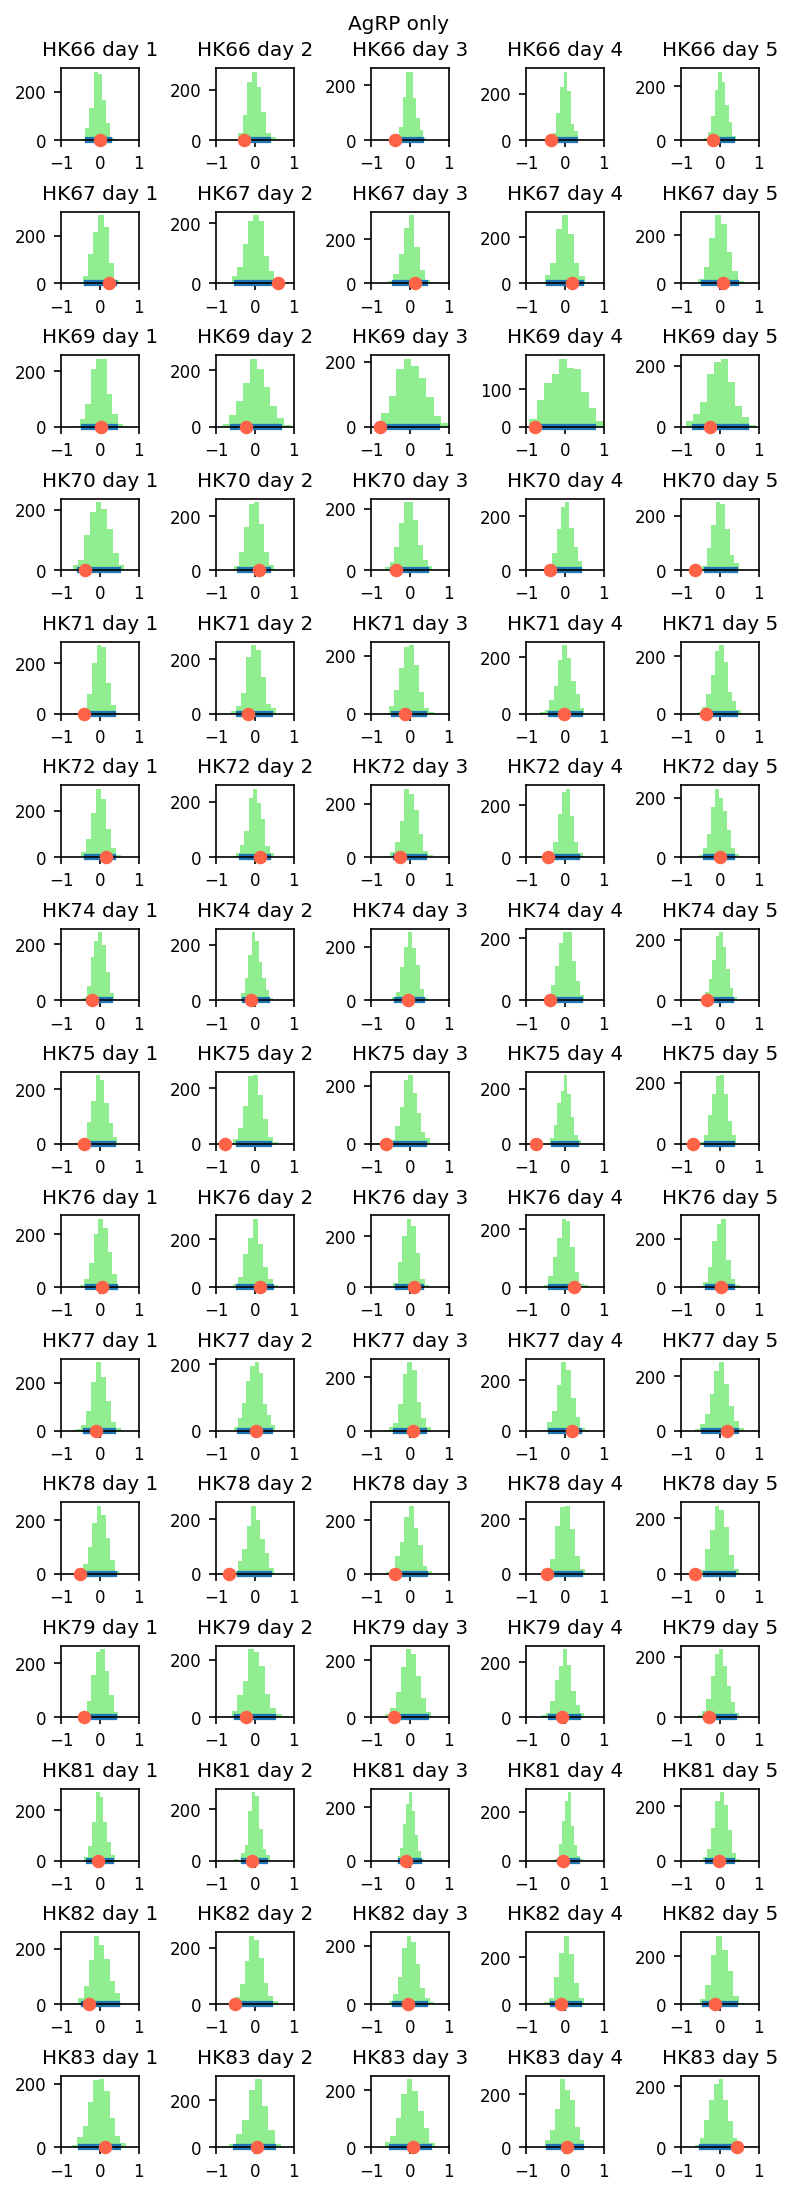

In [5]:
shuffle_n = 1000

m = len(males)
n = 5
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=1)
fig.suptitle('AgRP only', y=0.9)
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment, day), df in tqdm(table.query("experiment in ['test']").groupby(['mouse','experiment','day'])):
    if len(df):
        trial_n = df.cueid.unique()
        stim_n = df.query('stim>0 & session in [1,2]').stim.unique()
        neutral_n = df.query('neutral>0 & session in [1,2]').neutral.unique()
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials = np.random.choice(trial_n, size=len(stim_n), replace=False)
            neutral_trials = np.random.choice(trial_n, size=len(neutral_n), replace=False)
            
            stim_t = df.query("cueid in @stim_trials & dwell==True & session in [1,2]").dt.sum()
            neutral_t = df.query("cueid in @neutral_trials & dwell==True & session in [1,2]").dt.sum()
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci5, ci95 = np.quantile(pref_dist, [.025, .975])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':day,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t = df.query("stim>0 & dwell==True & session in [1,2]").dt.sum()
        neutral_t = df.query("neutral>0 & dwell==True & session in [1,2]").dt.sum()

        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':day,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen');
        ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        ax.set_title(f"{mouse} day {day}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci5,ci95], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_male_test = pref_df
pref_dist_df_male_test = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci5, ci95 = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci5) | (pref >= ci95)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_male_test = pd.concat(p_df, ignore_index=True)

p_df_male_test.p_val.astype(int).sum()


### AgRP + stress days (**males**)

100%|██████████| 75/75 [05:34<00:00,  4.46s/it]


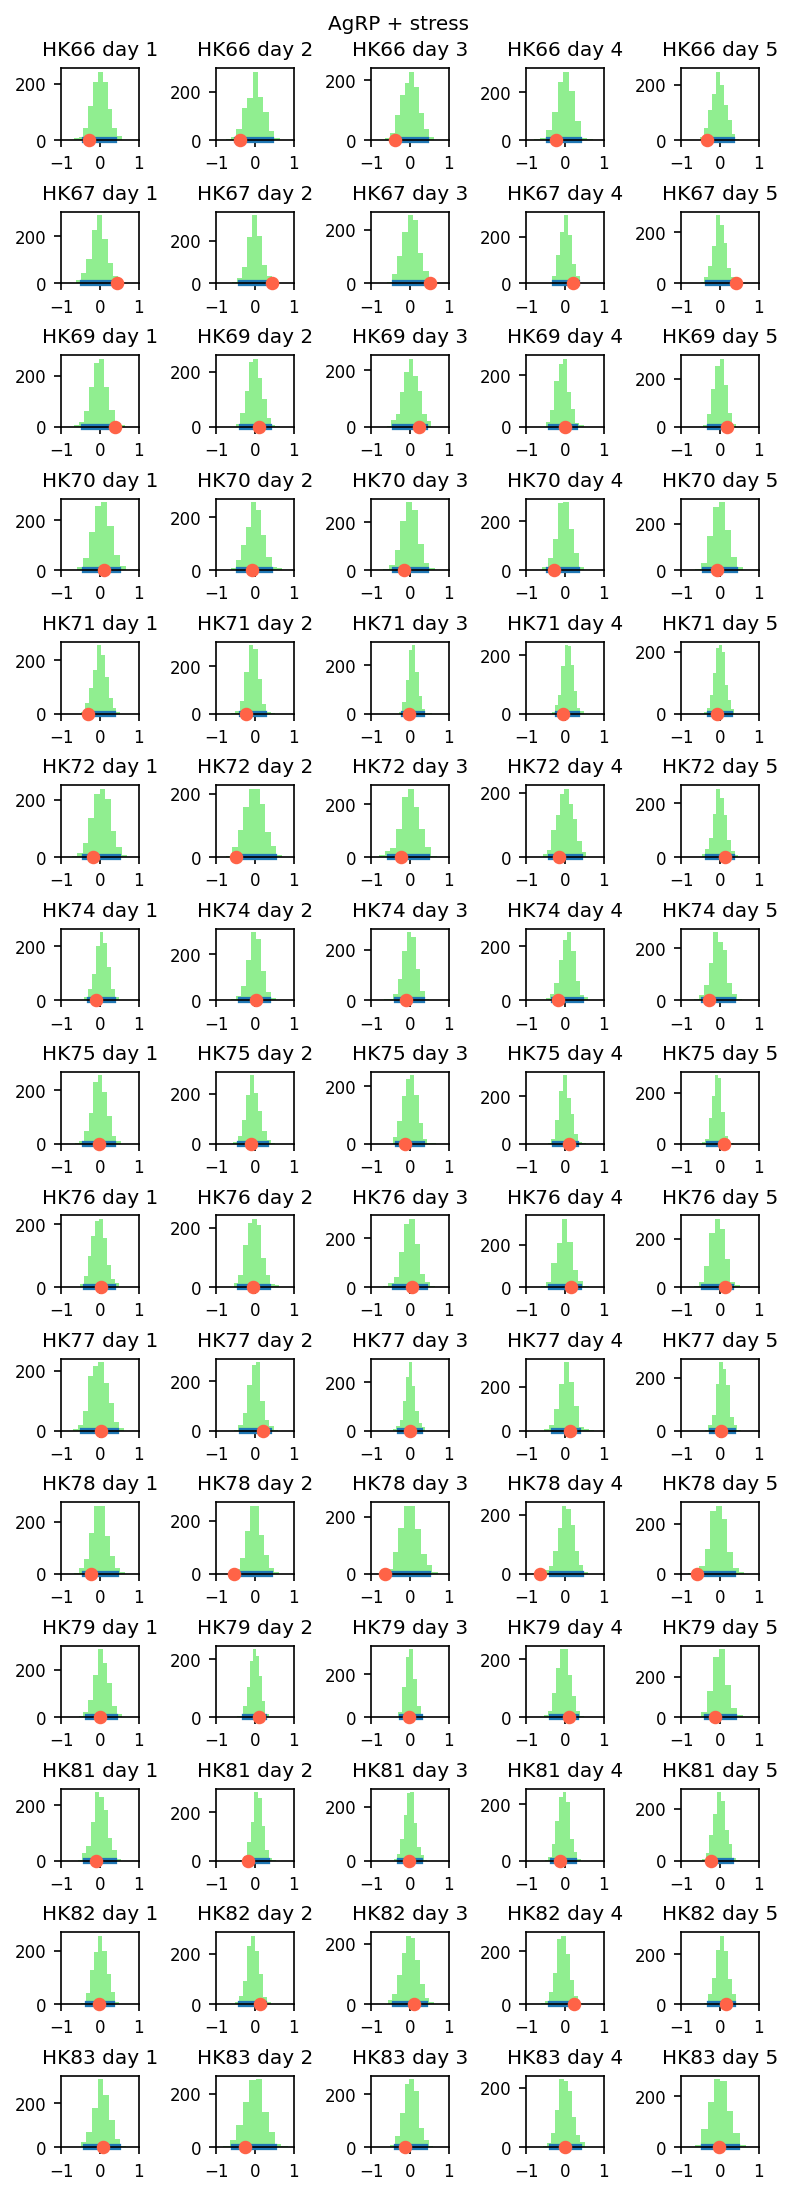

In [6]:
m = len(males)
n = 5
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=1)
fig.suptitle('AgRP + stress', y=0.9)
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment, day), df in tqdm(table.query("experiment in ['test_']").groupby(['mouse','experiment','day'])):
    if len(df):
        trial_n = df.cueid.unique()
        stim_n = df.query('stim>0 & session in [1,2]').stim.unique()
        neutral_n = df.query('neutral>0 & session in [1,2]').neutral.unique()
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials = np.random.choice(trial_n, size=len(stim_n), replace=False)
            neutral_trials = np.random.choice(trial_n, size=len(neutral_n), replace=False)
            
            stim_t = df.query("cueid in @stim_trials & dwell==True & session in [1,2]").dt.sum()
            neutral_t = df.query("cueid in @neutral_trials & dwell==True & session in [1,2]").dt.sum()
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci5, ci95 = np.quantile(pref_dist, [.025, .975])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':day,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t = df.query("stim>0 & dwell==True & session in [1,2]").dt.sum()
        neutral_t = df.query("neutral>0 & dwell==True & session in [1,2]").dt.sum()

        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':day,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen')
        ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        ax.set_title(f"{mouse} day {day}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci5,ci95], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_male_test_ = pref_df
pref_dist_df_male_test_ = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci5, ci95 = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci5) | (pref >= ci95)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_male_test_ = pd.concat(p_df, ignore_index=True)
p_val_male = pd.concat([p_df_male_preference, p_df_male_test, p_df_male_test_], ignore_index=True)


### Significance heatmaps (**males**)

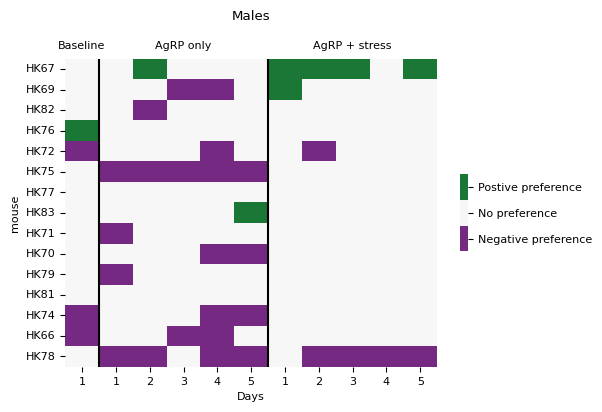

In [7]:
import seaborn as sns

mice = data_df.sort_values(('test_',5), ascending=False).query("@data_df.mouse.sex=='male'")[('mouse','mouse')].to_numpy()

sig_df = p_val_male.pivot_table(index=['mouse'], columns=['experiment','day'], values=['p_val'])
sig_df = sig_df.reindex(mice)

fig, ax = plt.subplots(1,1, figsize=(6,4))

im = sns.heatmap(sig_df, cmap=cmap, ax=ax, 
                 cbar_kws={"ticks":[-0.67,0,0.67], "aspect":10, 'shrink':0.25}, 
                 annot=False, annot_kws={"size":8})

ax.set_title("Males", y=1.1)
# ax.set_xticks([0,3,8])
ax.set_xticklabels([1,1,2,3,4,5,1,2,3,4,5], rotation=0)
ax.set_xlabel('Days')

ax.text(x=0.5, y=-0.5, s='Baseline', ha='center')
ax.text(x=3.5, y=-0.5, s='AgRP only', ha='center')
ax.text(x=8.5, y=-0.5, s='AgRP + stress', ha='center')

ax.plot([1,1], [0,17], color='black')
ax.plot([6,6], [0,17], color='black')

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['Negative preference', 'No preference', 'Postive preference'])


In [8]:
pref_df_male = pd.concat([pref_df_male_preference, 
                            pref_df_male_test, 
                            pref_df_male_test_], ignore_index=True)

pref_df_male = pd.concat([pref_df_male.query("mouse==@mouse") for mouse in mice])

pref = pref_df_male.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:x, sort=False)


pref_dist_df_male = pd.concat([pref_dist_df_male_preference, 
                                 pref_dist_df_male_test, 
                                 pref_dist_df_male_test_], ignore_index=True)

ci_lo = pref_dist_df_male.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:np.quantile(x.to_numpy(),0.025))
ci_hi = pref_dist_df_male.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:np.quantile(x.to_numpy(),0.975))

ci_lo.columns = ['ci_lo']
ci_hi.columns = ['ci_hi']
pref_df = pd.concat([pref, ci_lo, ci_hi], axis=1)


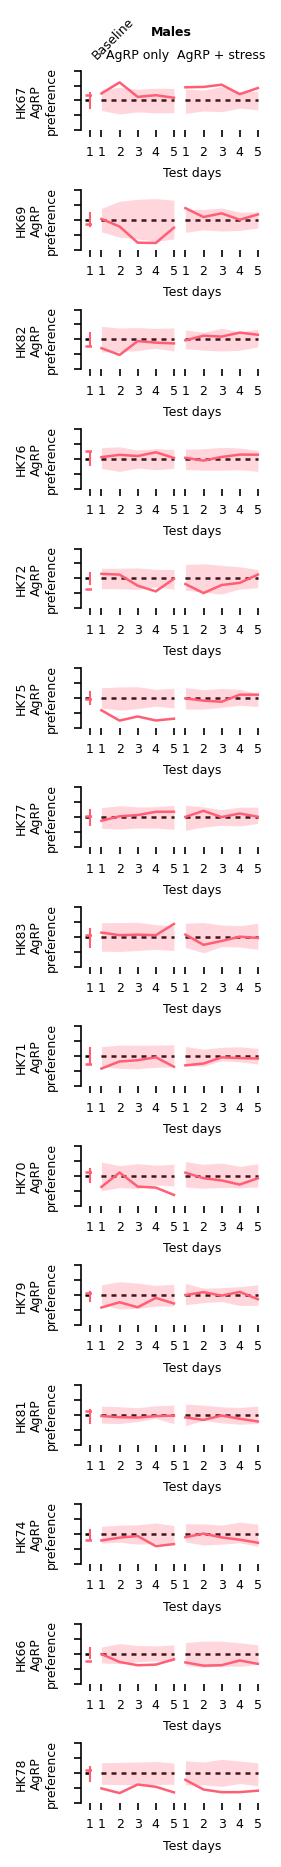

In [9]:
titles = ['Baseline', 'AgRP only', 'AgRP + stress']

fig, axs = plt.subplots(len(males),3, figsize=(1.6,len(males)*1), dpi=150, gridspec_kw={'width_ratios':[1,5,5]})
fig.subplots_adjust(wspace=-0.1,hspace=1)
fig.suptitle('Males', y=0.9, fontsize=6, fontweight='bold')

axs[0,0].set_title('Baseline', fontsize=6, rotation=45, ha='left')
axs[0,1].set_title('AgRP only', fontsize=6, ha='center')
axs[0,2].set_title('AgRP + stress', fontsize=6, ha='center')

for n, ((mouse,), mouse_df) in enumerate(pref_df.groupby(['mouse'], sort=False)):
    # fig.suptitle(f'{mouse}', x=0.1, y=1.2)
#     axs[n,0].set_ylabel(f'{mouse}\nAgRP preference')
    axs[n,0].set_ylabel(f'{mouse}\nAgRP\npreference', fontsize=6)
    
    for e, ((experiment,), df) in enumerate(mouse_df.groupby(['experiment'], sort=False)):
        days = df.index.get_level_values(2).to_numpy()
        
        ax = axs[n,e]
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_ylim([-1,1])
        ax.set_xlim([np.min(days)-0.5,np.max(days)+0.5])
        if e==0: 
            ax.set_yticks([-1,-0.5,0,0.5,1])
            ax.set_yticklabels([])
        else: 
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        
        ax.set_xticks(days)
        ax.set_xticklabels(days, fontsize=6)
        if e==2: ax.set_xlabel('Test days', fontsize=6, ha='right')
        
        if experiment=='preference':
            ax.scatter(days, df.pref, marker='_', s=20, linewidth=1.2, color=colors['male'])
            ax.plot([days,days], [df.ci_lo,df.ci_hi], color=colors['male'], linewidth=1, zorder=9)
            ax.plot([days-0.3,days+0.3], np.repeat([0], 2), linestyle=(0,(2,2)), color='black', linewidth=1.2, zorder=-9)
        else:
            ax.plot(days, df.pref, linewidth=1.2, color=colors['male'], zorder=9)
            ax.fill_between(days, df['ci_lo'].to_numpy(), df['ci_hi'].to_numpy(), 
                            color=colors['male'], linewidth=0, zorder=-1, alpha=0.25)
            ax.plot(days, np.repeat([0], len(days)), linestyle=(0,(2,2)), color='black', linewidth=1.2, zorder=-9)
            

## Figure S2B

### Calculate the null distributions for the preferences of female mice

In [10]:
# Load the raw behavior data
data_path = basedir/'Kucukdereli_atal_data/raw_behavior_data_females.h5'
table = pd.read_hdf(data_path, key='data')

# Sort the data by the preference from the day 5 of RTPP
females = data_df.sort_values([('test_',5)]).query('@data_df.mouse.sex=="female"')['mouse','mouse'].to_numpy()
table = pd.concat([table.query('mouse==@mouse') for mouse in females], ignore_index=True)


### Baseline days (**females**)

100%|██████████| 17/17 [01:56<00:00,  6.83s/it]


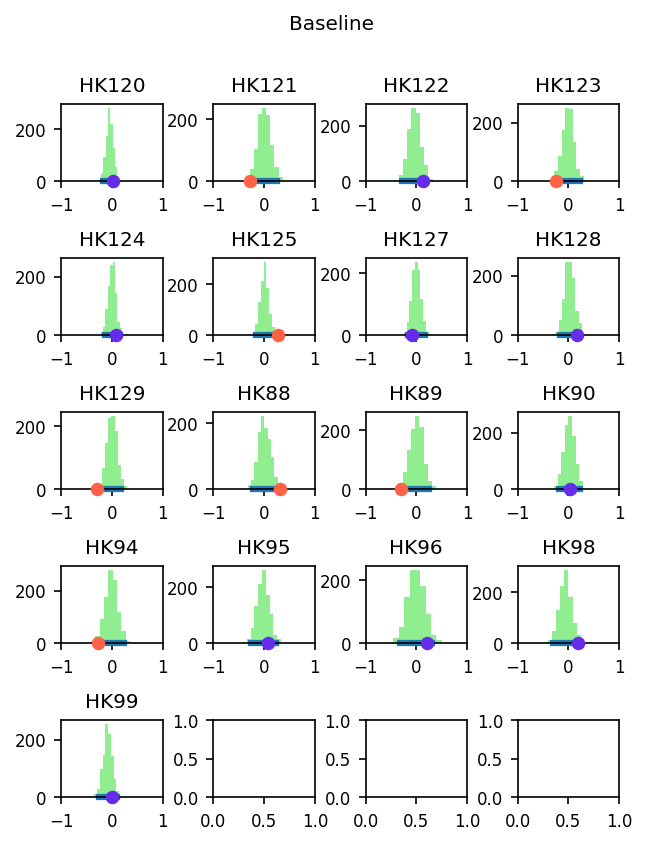

In [14]:
shuffle_n = 1000

m = np.ceil(np.sqrt(len(females))).astype(int)
n = np.ceil(len(females)/m).astype(int)
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=0.5)
fig.suptitle('Baseline')
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment), df in tqdm(table.query("experiment in ['preference'] & day in [1,2]").groupby(['mouse','experiment'])):
    if len(df):
        trial_n1 = df.query("day==1").query("session==1").cueid.unique()
        stim_n1 = df.query("day==1").query('stim>0 & session==1').stim.unique()
        neutral_n1 = df.query("day==1").query('neutral>0 & session==1').neutral.unique()
        trial_n2 = df.query("day==2").query("session==1").cueid.unique()
        stim_n2 = df.query("day==2").query('stim>1 & session==1').stim.unique()
        neutral_n2 = df.query("day==2").query('neutral>0 & session==1').neutral.unique()
        
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials1 = np.random.choice(trial_n1, size=len(stim_n1), replace=False)
            neutral_trials1 = np.random.choice(trial_n1, size=len(neutral_n1), replace=False)
            stim_trials2 = np.random.choice(trial_n2, size=len(stim_n2), replace=False)
            neutral_trials2 = np.random.choice(trial_n2, size=len(neutral_n2), replace=False)
            
            stim_t1 = df.query("day==1 & cueid in @stim_trials1 & dwell==True & session==1").dt.sum()
            neutral_t1 = df.query("day==1 & cueid in @neutral_trials1 & dwell==True & session==1").dt.sum()
            stim_t2 = df.query("day==2 & cueid in @stim_trials2 & dwell==True & session==1").dt.sum()
            neutral_t2 = df.query("day==2 & cueid in @neutral_trials2 & dwell==True & session==1").dt.sum()
            stim_t = stim_t1 + stim_t2
            neutral_t = neutral_t1 + neutral_t2
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci_lo, ci_hi = np.quantile(pref_dist, [.025, .975])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':1,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t1 = df.query("day==1 & stim>0 & dwell==True & session==1").dt.sum()
        neutral_t1 = df.query("day==1 & neutral>0 & dwell==True & session==1").dt.sum()
        stim_t2 = df.query("day==2 & stim>0 & dwell==True & session==1").dt.sum()
        neutral_t2 = df.query("day==2 & neutral>0 & dwell==True & session==1").dt.sum()
        stim_t = stim_t1 + stim_t2
        neutral_t = neutral_t1 + neutral_t2
            
        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':1,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen')
        if (pref>ci_hi or pref<ci_lo):
            ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        else:
            ax.scatter(pref, 0, s=30, c='xkcd:purple blue', clip_on=False, zorder=99)
        ax.set_title(f"{mouse}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci_lo,ci_hi], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_female_preference = pref_df
pref_dist_df_female_preference = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci_lo, ci_hi = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci_lo) | (pref >= ci_hi)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_female_preference = pd.concat(p_df, ignore_index=True)


### AgRP only days (**females**)

100%|██████████| 85/85 [05:42<00:00,  4.03s/it]


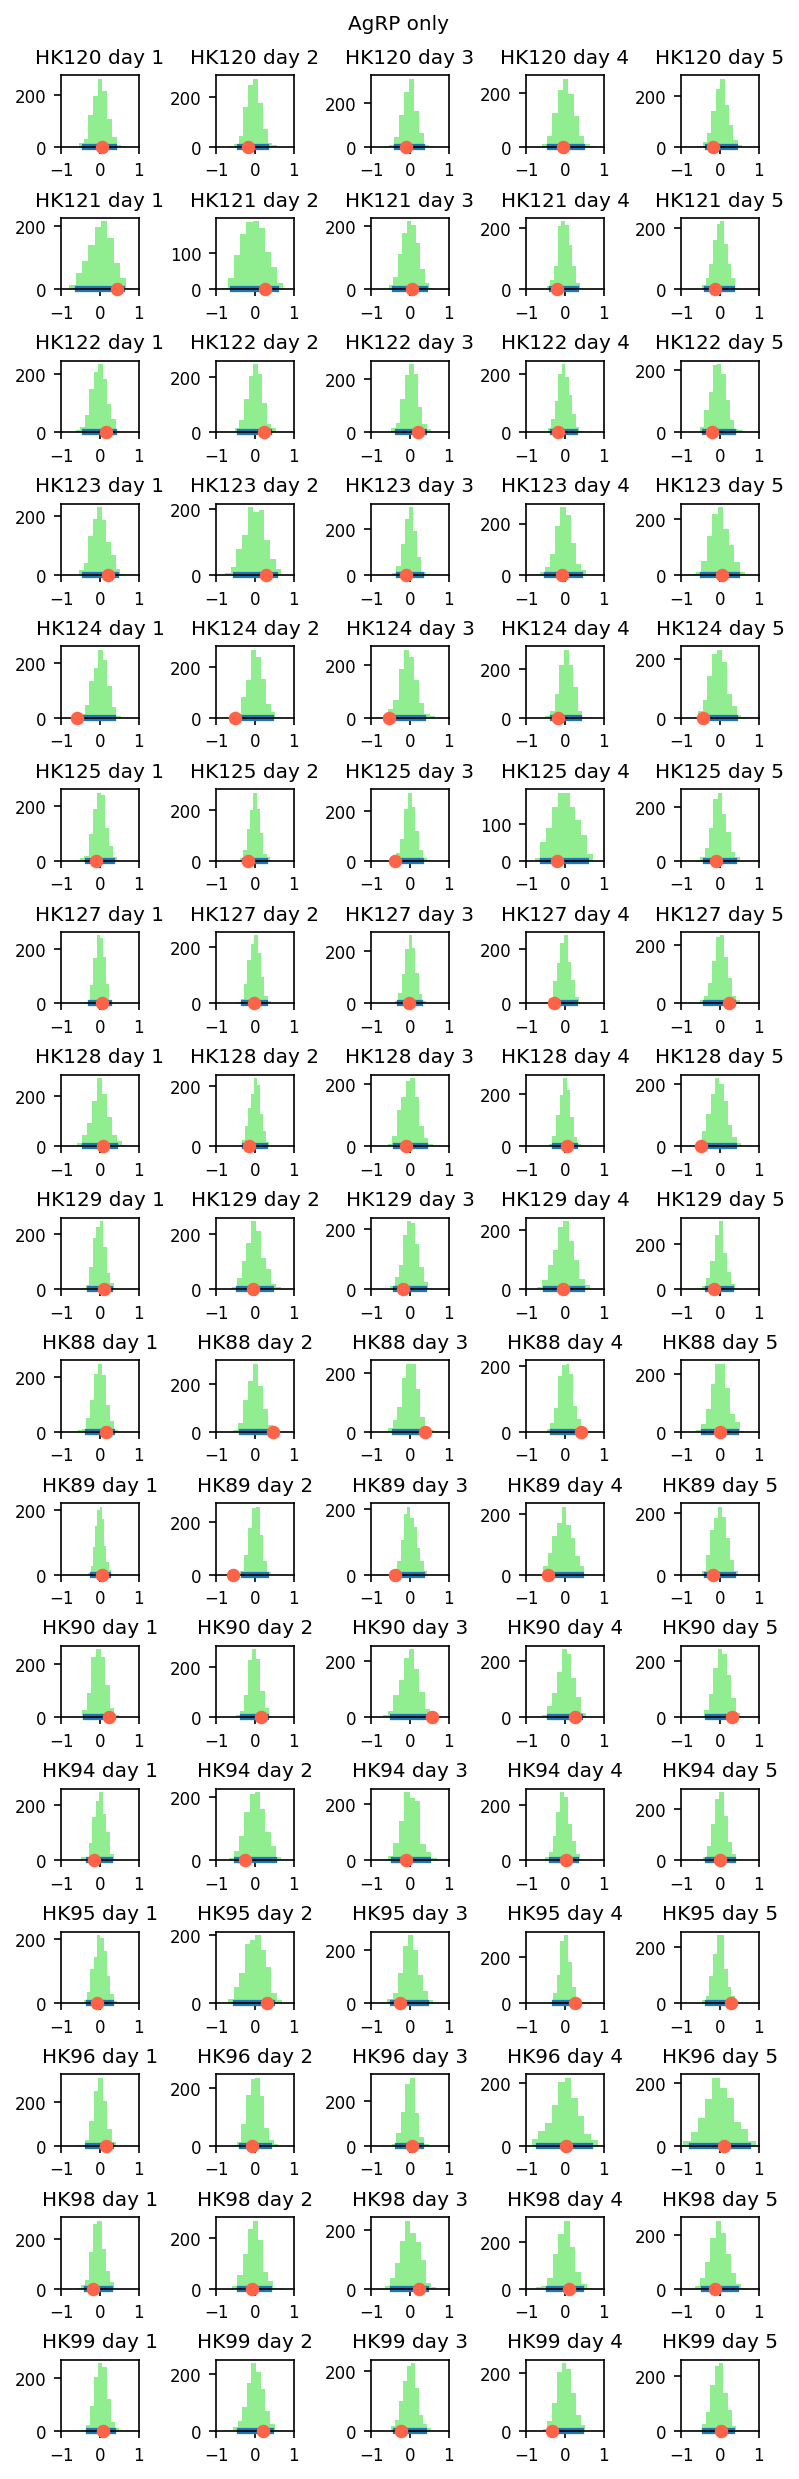

In [16]:
shuffle_n = 1000

m = len(females)
n = 5
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=1)
fig.suptitle('AgRP only', y=0.9)
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment, day), df in tqdm(table.query("experiment in ['test']").groupby(['mouse','experiment','day'])):
    if len(df):
        trial_n = df.cueid.unique()
        stim_n = df.query('stim>0 & session in [1,2]').stim.unique()
        neutral_n = df.query('neutral>0 & session in [1,2]').neutral.unique()
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials = np.random.choice(trial_n, size=len(stim_n), replace=False)
            neutral_trials = np.random.choice(trial_n, size=len(neutral_n), replace=False)
            
            stim_t = df.query("cueid in @stim_trials & dwell==True & session in [1,2]").dt.sum()
            neutral_t = df.query("cueid in @neutral_trials & dwell==True & session in [1,2]").dt.sum()
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci_lo, ci_hi = np.quantile(pref_dist, [.025, .975])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':day,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t = df.query("stim>0 & dwell==True & session in [1,2]").dt.sum()
        neutral_t = df.query("neutral>0 & dwell==True & session in [1,2]").dt.sum()

        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':day,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen');
        ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        ax.set_title(f"{mouse} day {day}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci_lo,ci_hi], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_female_test = pref_df
pref_dist_df_female_test = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci5, ci95 = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci5) | (pref >= ci95)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_female_test = pd.concat(p_df, ignore_index=True)


### AgRP + stress days (**females**)

100%|██████████| 85/85 [05:58<00:00,  4.22s/it]


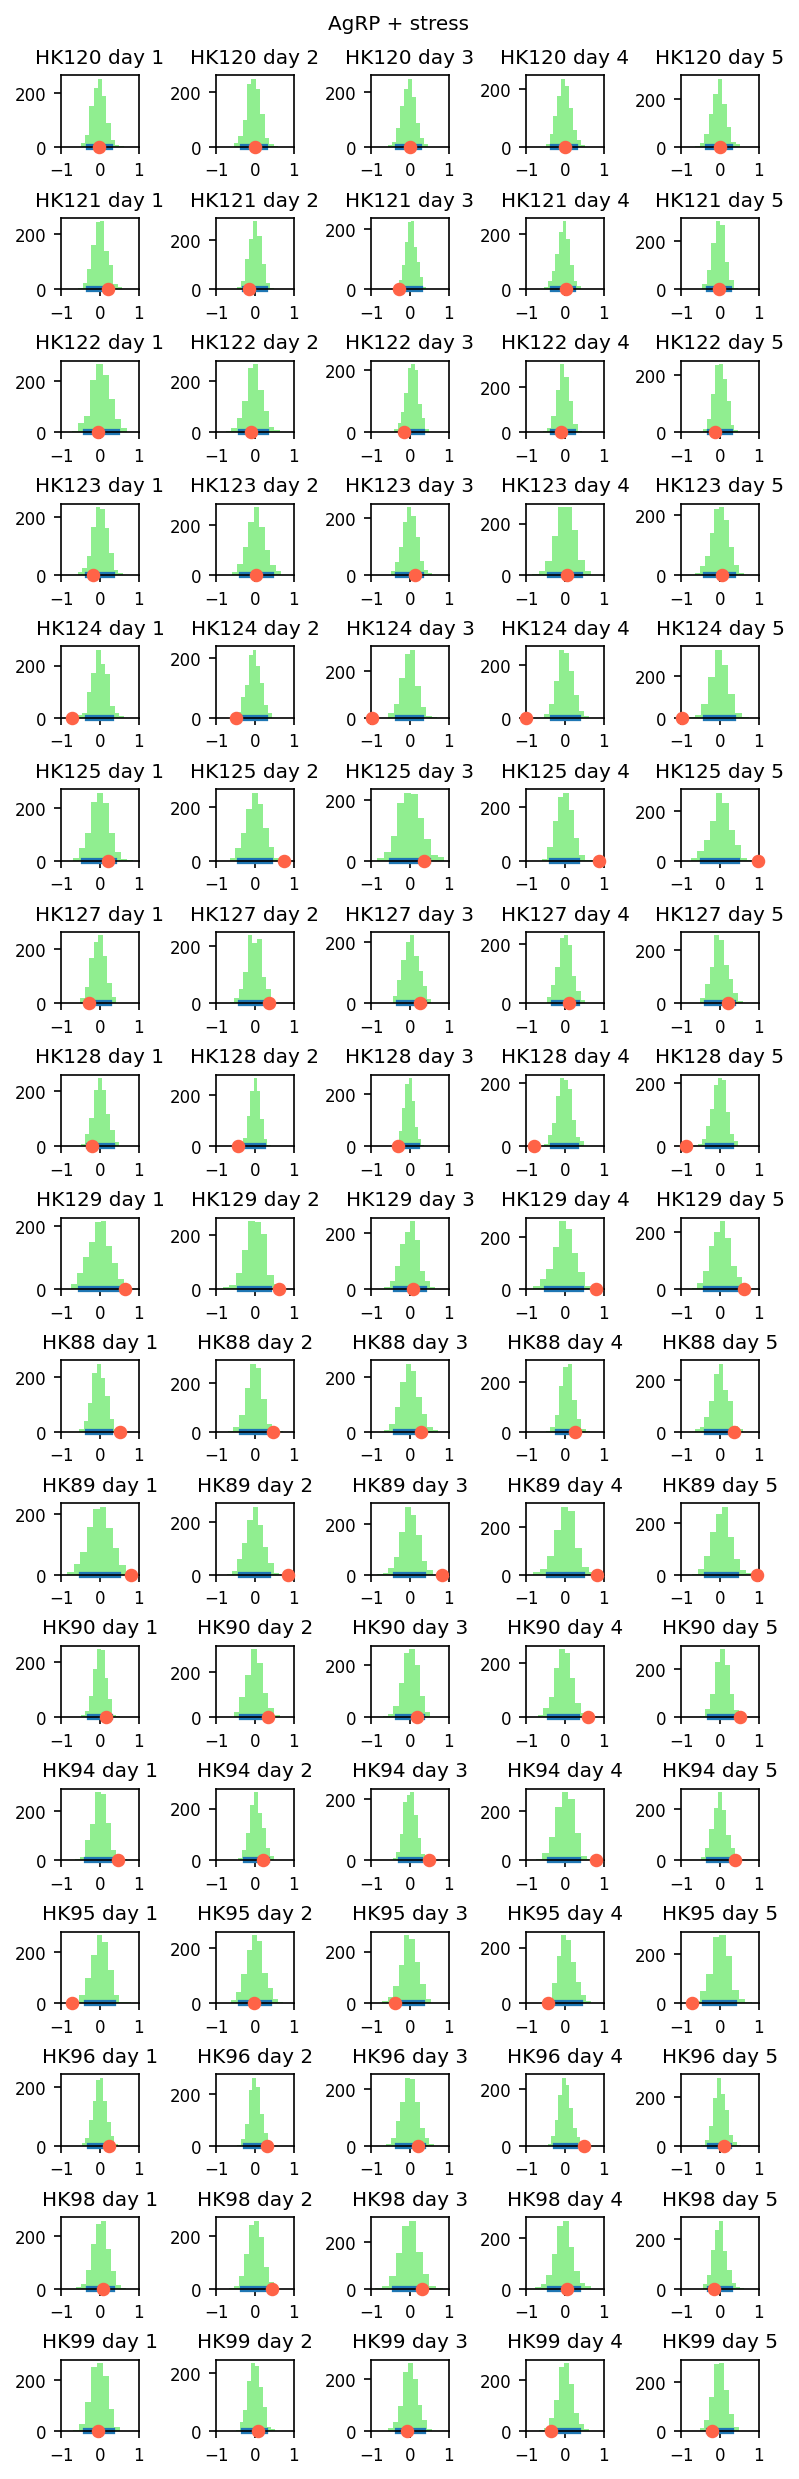

In [17]:
shuffle_n = 1000

m = len(females)
n = 5
fig, axs = plt.subplots(m,n, figsize=(n*1.2,m*1.2), dpi=150)
fig.subplots_adjust(hspace=1, wspace=1)
fig.suptitle('AgRP + stress', y=0.9)
axs = axs.ravel()

pref_df, pref_dist_df = [], []

c = 0
for (mouse, experiment, day), df in tqdm(table.query("experiment in ['test_']").groupby(['mouse','experiment','day'])):
    if len(df):
        trial_n = df.cueid.unique()
        stim_n = df.query('stim>0 & session in [1,2]').stim.unique()
        neutral_n = df.query('neutral>0 & session in [1,2]').neutral.unique()
        
        # Calculate shuffled preferences
        pref_dist = []
        for i in range(shuffle_n):
            stim_trials = np.random.choice(trial_n, size=len(stim_n), replace=False)
            neutral_trials = np.random.choice(trial_n, size=len(neutral_n), replace=False)
            
            stim_t = df.query("cueid in @stim_trials & dwell==True & session in [1,2]").dt.sum()
            neutral_t = df.query("cueid in @neutral_trials & dwell==True & session in [1,2]").dt.sum()
            
            pref = (stim_t - neutral_t) / (stim_t + neutral_t)
            pref_dist.append(pref)
        ci5, ci95 = np.quantile(pref_dist, [.05, .95])
        pref_dist_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                         'experiment':experiment,'day':day,
                                         'pref':np.sort(pref_dist)}))
        
        stim_t = df.query("stim>0 & dwell!=0 & session in [1,2]").dt.sum()
        neutral_t = df.query("neutral>0 & dwell!=0 & session in [1,2]").dt.sum()

        pref = (stim_t - neutral_t) / (stim_t + neutral_t)
        pref_df.append(pd.DataFrame({'mouse':mouse,'date':df.date.unique()[0],
                                     'experiment':experiment,'day':day,
                                     'pref':pref}, index=[0]))
        
        ax = axs[c]
        ax.hist(pref_dist, color='lightgreen')
        ax.scatter(pref, 0, s=30, c='tomato', clip_on=False, zorder=99)
        ax.set_title(f"{mouse} day {day}")
        ax.set_xlim([-1,1])
        
        ax.plot([ci5,ci95], [0,0], linewidth=3, clip_on=False)
    
    c = c + 1
    
pref_df = pd.concat(pref_df, ignore_index=True)
pref_dist_df = pd.concat(pref_dist_df, ignore_index=True)
pref_df_female_test_ = pref_df
pref_dist_df_female_test_ = pref_dist_df

p_df = []
for (mouse, experiment, day), df in pref_dist_df.groupby(['mouse','experiment','day']):
    pref = pref_df.query("mouse==@mouse & experiment==@experiment & day==@day").pref
    ci5, ci95 = np.quantile(df.pref, [.025,.975])
    p_val = (pref <= ci5) | (pref >= ci95)
    p_val = p_val * np.sign(pref)
    
    p_df.append(pd.DataFrame({'mouse':mouse, 'date':df.date.unique(), 
                              'experiment':experiment, 'day':day, 'p_val':p_val}))

p_df_female_test_ = pd.concat(p_df, ignore_index=True)
p_val_female = pd.concat([p_df_female_preference, p_df_female_test, p_df_female_test_], ignore_index=True)


### Significance heatmaps (**females**)

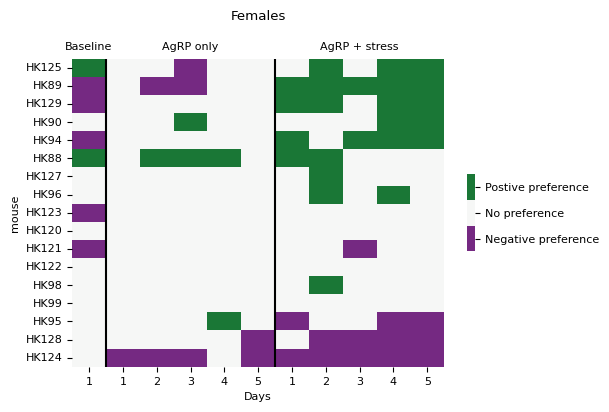

In [18]:
import seaborn as sns

mice = data_df.sort_values(('test_',5), ascending=False).query("@data_df.mouse.sex=='female'")[('mouse','mouse')].to_numpy()

sig_df = p_val_female.pivot_table(index=['mouse'], columns=['experiment','day'], values=['p_val'])
sig_df = sig_df.reindex(mice)

fig, ax = plt.subplots(1,1, figsize=(6,4))

im = sns.heatmap(sig_df, cmap=cmap, ax=ax, 
                 cbar_kws={"ticks":[-0.67,0,0.67], "aspect":10, 'shrink':0.25}, 
                 annot=False, annot_kws={"size":8})

ax.set_title("Females", y=1.1)
# ax.set_xticks([0,3,8])
ax.set_xticklabels([1,1,2,3,4,5,1,2,3,4,5], rotation=0)
ax.set_xlabel('Days')

ax.text(x=0.5, y=-0.5, s='Baseline', ha='center')
ax.text(x=3.5, y=-0.5, s='AgRP only', ha='center')
ax.text(x=8.5, y=-0.5, s='AgRP + stress', ha='center')

ax.plot([1,1], [0,17], color='black')
ax.plot([6,6], [0,17], color='black')

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['Negative preference', 'No preference', 'Postive preference'])


In [20]:
pref_df_female = pd.concat([pref_df_female_preference, 
                            pref_df_female_test, 
                            pref_df_female_test_], ignore_index=True)

pref_df_female = pd.concat([pref_df_female.query("mouse==@mouse") for mouse in mice])

pref = pref_df_female.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:x, sort=False)


pref_dist_df_female = pd.concat([pref_dist_df_female_preference, 
                                 pref_dist_df_female_test, 
                                 pref_dist_df_female_test_], ignore_index=True)

ci_lo = pref_dist_df_female.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:np.quantile(x.to_numpy(),0.025))
ci_hi = pref_dist_df_female.pivot_table(index=['mouse','experiment','day'], 
                                                 values=['pref'], 
                                                 aggfunc=lambda x:np.quantile(x.to_numpy(),0.975))

ci_lo.columns = ['ci_lo']
ci_hi.columns = ['ci_hi']
pref_df = pd.concat([pref, ci_lo, ci_hi], axis=1)


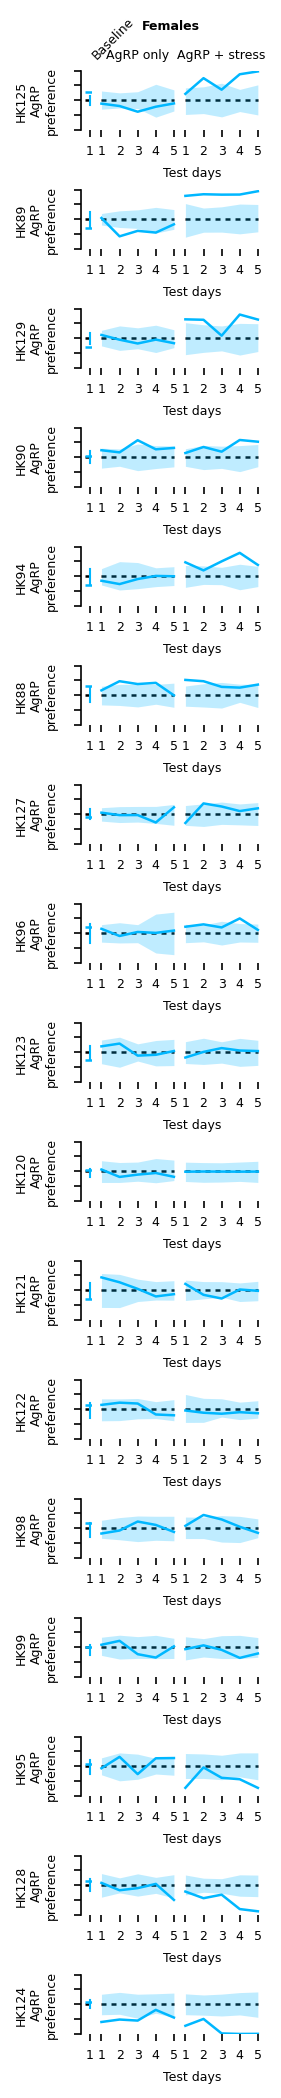

In [22]:
titles = ['Baseline', 'AgRP only', 'AgRP + stress']

fig, axs = plt.subplots(len(females),3, figsize=(1.6,len(females)*1), dpi=150, gridspec_kw={'width_ratios':[1,5,5]})
fig.subplots_adjust(wspace=-0.1,hspace=1)
fig.suptitle('Females', y=0.9, fontsize=6, fontweight='bold')

axs[0,0].set_title('Baseline', fontsize=6, rotation=45, ha='left')
axs[0,1].set_title('AgRP only', fontsize=6, ha='center')
axs[0,2].set_title('AgRP + stress', fontsize=6, ha='center')

for n, ((mouse,), mouse_df) in enumerate(pref_df.groupby(['mouse'], sort=False)):
    # fig.suptitle(f'{mouse}', x=0.1, y=1.2)
#     axs[n,0].set_ylabel(f'{mouse}\nAgRP preference')
    axs[n,0].set_ylabel(f'{mouse}\nAgRP\npreference', fontsize=6)
    
    for e, ((experiment,), df) in enumerate(mouse_df.groupby(['experiment'], sort=False)):
        days = df.index.get_level_values(2).to_numpy()
        
        ax = axs[n,e]
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_ylim([-1,1])
        ax.set_xlim([np.min(days)-0.5,np.max(days)+0.5])
        if e==0: 
            ax.set_yticks([-1,-0.5,0,0.5,1])
            ax.set_yticklabels([])
        else: 
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        
        ax.set_xticks(days)
        ax.set_xticklabels(days, fontsize=6)
        if e==2: ax.set_xlabel('Test days', fontsize=6, ha='right')
        
        if experiment=='preference':
            ax.scatter(days, df.pref, marker='_', s=20, linewidth=1.2, color=colors['female'])
            ax.plot([days,days], [df.ci_lo,df.ci_hi], color=colors['female'], linewidth=1, zorder=9)
            ax.plot([days-0.3,days+0.3], np.repeat([0], 2), linestyle=(0,(2,2)), color='black', linewidth=1.2, zorder=-9)
        else:
            ax.plot(days, df.pref, linewidth=1.2, color=colors['female'], zorder=9)
            ax.fill_between(days, df['ci_lo'].to_numpy(), df['ci_hi'].to_numpy(), 
                            color=colors['female'], linewidth=0, zorder=-1, alpha=0.25)
            ax.plot(days, np.repeat([0], len(days)), linestyle=(0,(2,2)), color='black', linewidth=1.2, zorder=-9)
            